In [1]:
import itertools
from pathlib import Path

import mne
import nltk
import numpy as np
import pandas as pd
import re
import scipy.io
from tqdm.notebook import tqdm

# Transformers prep
import os
os.environ["TRANSFORMERS_CACHE"] = str((Path(".") / "transformers_cache").resolve())
import transformers
import torch
RECOMPUTE_SURPRISALS = False

DATA_DIR = Path("/om/data/public/broderick2018/Natural Speech")
EEG_DIR = DATA_DIR / "EEG"
STIM_DIR = DATA_DIR / "Stimuli" / "Text"
ENVELOPE_DIR = DATA_DIR / "Stimuli" / "Envelopes"

FULL_TEXT_PATH = Path("data/texts/old-man-and-the-sea.txt")

SURPRISALS_DIR = Path("data/surprisals")
# SURPRISALS_HF_MODEL = "hf-internal-testing/tiny-xlm-roberta" #"gpt2"
SURPRISALS_HF_MODEL = "EleutherAI/gpt-neo-125M"
SURPRISALS_CHECKPOINT_PATH = SURPRISALS_DIR / ("surprisals_" + SURPRISALS_HF_MODEL.replace("/", "-") + ".csv")

In [2]:
# Metadata for Broderick et al 2018
NUM_DATA_CHANNELS = 128
# 2 mastoid channels
NUM_REFERENCE_CHANNELS = 2
NUM_CHANNELS = NUM_DATA_CHANNELS + NUM_REFERENCE_CHANNELS
SAMPLE_RATE = 128

data_channels = [f"V{i + 1}" for i in range(NUM_DATA_CHANNELS)]
reference_channels = [f"M{i + 1}" for i in range(NUM_REFERENCE_CHANNELS)]
channel_names = data_channels + reference_channels

# EEG Processing parameters
EPOCH_WINDOW = (-0.2, 0.5)
TEST_WINDOW = (0.3, 0.5)

# EEG band-pass filter parameters
FILTER_LOW = 1.
FILTER_HIGH = 8.

In [3]:
%load_ext autoreload
%autoreload 2
import utils

Reference: https://mne.tools/stable/auto_tutorials/evoked/30_eeg_erp.html#sphx-glr-auto-tutorials-evoked-30-eeg-erp-py

## TODO

- other preprocessing which might be necessary
  - ICA
  - eye movement artifact removal

## Glossary

- preprocessing steps
  - detrending: Subtract least-square linear fit from time series, cf. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html
  - baselining: Subtract per-channel mean from signal
  - decimating: Data subsampling (over time)
  
## Changes to match Frank et al. 2015

- N400 window: 300-500 ms
- drop sentence-final words
- no baselining. instead, include t=0 potential as a control predictor in mixef model
- mixed effects model
    - control predictors
        - log word frequency
        - word length
        - word position in sentence
        - sentence position
- modulus transformation

## Load stimuli

In [4]:
stim_paths = list(STIM_DIR.glob("*.mat"))
stim_df = pd.concat([utils.load_stimuli(path) for path in stim_paths],
                    keys=[int(p.stem.replace("Run", "")) for p in stim_paths],
                    names=["item", "content_word_idx"]).sort_index()
stim_df

word  onset_time  offset_time
item content_word_idx                                    
1    0                       OLD        1.12         1.41
     1                       MAN        1.41         1.79
     2                    FISHED        2.08         2.41
     3                     ALONE        2.41         2.77
     4                     SKIFF        2.95         3.41
...                          ...         ...          ...
20   250               NECESSARY      184.43       184.93
     251                    FREE      185.06       185.42
     252                   UNTIE      185.56       186.00
     253                 VARIOUS      186.11       186.57
     254                   LINES      186.57       187.07

[5459 rows x 3 columns]

### Align stimuli with original text and surprisals

We will simultaneously run this alignment, accounting for differences in tokenization and in words missing in the stimuli (which only contain "content words").

In [5]:
sentences = nltk.tokenize.PunktSentenceTokenizer().tokenize(FULL_TEXT_PATH.open().read())
sentences = [nltk.tokenize.RegexpTokenizer("[\w']+|[^\w\s]+").tokenize(sent) for sent in sentences]
tokens_flat = [tok for sent in sentences for tok in sent]

In [6]:
## Align stimulus rows with full text content, in preparation
## for re-inserting non-content words.

punct_re = re.compile(r"[^A-Za-z]")

stop = False

tok_cursor = 0
surp_cursor = 0

tok_el = tokens_flat[tok_cursor]
# surp_el = surprisals_df.iloc[surp_cursor]

# For each element in surp_df, record the index of the corresponding element
# in the token sequence or surprisal df.
tok_pos, surp_pos = [], []
for item, rows in tqdm(stim_df.groupby("item")):
    if stop: break
        
    # print("==========", item)
    for idx, row in rows.iterrows():
        # print(row.word, "::")
        
        # Track how many elements in a reference we have skipped. If this is excessive,
        # we'll quit rather than looping infinitely.
        skip_count = 0
        if stop: break
        
        # Find corresponding token in text and append to `tok_pos`.
        try:
            tok_el = punct_re.sub("", tok_el)
            while not tok_el.startswith(row.word.lower()):
                tok_cursor += 1
                skip_count += 1
                if skip_count > 20:
                    stop = True
                    break
                
                tok_el = utils.strip_accents(tokens_flat[tok_cursor].lower())
                # print("\t//", element)
                
            # print("\tMatch", row.word, element)
            tok_pos.append(tok_cursor)

            # If we matched only a subset of the token, then cut off what we
            # matched and proceed.
            if tok_el != row.word.lower():
                tok_el = tok_el[len(row.word):]
        except IndexError:
            print("iex", row, tok_cursor, tok_el)
            stop = True
            break
            
stim_df["tok_pos"] = tok_pos

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
if RECOMPUTE_SURPRISALS:
    hf_tokenizer = transformers.AutoTokenizer.from_pretrained(SURPRISALS_HF_MODEL)
    hf_model = transformers.AutoModelForCausalLM.from_pretrained(SURPRISALS_HF_MODEL,
                                                                 add_cross_attention=True, is_decoder=True)

    tokenized = hf_tokenizer.batch_encode_plus(
        [" ".join(sentence) for sentence in sentences],
        add_special_tokens=True, return_offsets_mapping=True)

    global_tok_cursor = 0

    # Each element is of form (global_text_tok_idx, sent_idx, text_tok_idx, tok_idx, surprisal)
    # `global_text_tok_idx` is an index into `tokens_flat`
    # `sent_idx` is an index into `sentences`
    # `text_tok_idx` is an index into `sentences[sent_idx]`
    surp_mapping = []
    for sent_idx, sentence in enumerate(tqdm(sentences)):
        sent_tokens = torch.tensor(tokenized["input_ids"][sent_idx]).unsqueeze(0)

        # Run batches of decoding, accounting for limited sequence input size
        max_len = 512
        past = None
        input_ids = sent_tokens.clone()
        surprisal_outputs = []
        while True:
            with torch.no_grad():
                outputs_b = hf_model(
                    input_ids=input_ids[:, :max_len],
                    past_key_values=past,
                    return_dict=True)

            # at most max_len * vocab_size
            surprisal_outputs.append(-outputs_b["logits"].log_softmax(dim=2).squeeze(0).numpy())

            past = outputs_b["past_key_values"]

            if input_ids.shape[1] <= max_len:
                # Done.
                break
            else:
                input_ids = input_ids[:, max_len:]

        # T * vocab_size
        all_surprisals = np.concatenate(surprisal_outputs, axis=0)

        # get surprisals of expected words
        surps_shifted = all_surprisals[:-1, :]
        sent_tokens_shifted = sent_tokens.squeeze()[1:]
        token_surps = surps_shifted[range(surps_shifted.shape[0]), sent_tokens_shifted]

        word_ids = tokenized.word_ids(sent_idx)
        for tok_id, surp in enumerate(token_surps):
            if word_ids[tok_id] is None:
                continue
            surp_mapping.append((global_tok_cursor + word_ids[tok_id],
                                 sent_idx, word_ids[tok_id], tok_id, surp))

        global_tok_cursor += len(sentence)

    surp_mapping = pd.DataFrame(surp_mapping, columns=["global_text_tok_idx", "sent_idx",
                                                       "text_tok_idx", "tok_idx", "surprisal"])
    
    surp_mapping.to_csv(SURPRISALS_CHECKPOINT_PATH)
else:
    surp_mapping = pd.read_csv(SURPRISALS_CHECKPOINT_PATH)

### Merge into `stim_df`

In [8]:
surp_mapping["token"] = surp_mapping.global_text_tok_idx.map(dict(enumerate(tokens_flat)))

In [9]:
surp_mapping.groupby(["global_text_tok_idx", "token"]).surprisal.sum()

global_text_tok_idx  token  
0                    He         2.660097
1                    was        3.965186
2                    an         3.409394
3                    old        1.007797
4                    man        2.824772
                                  ...   
12814                and        8.506883
12815                untie      3.200993
12816                the        7.338224
12817                various    6.563997
12818                lines      8.991981
Name: surprisal, Length: 12111, dtype: float64

In [10]:
stim_df = pd.merge(stim_df, surp_mapping.groupby(["global_text_tok_idx"]).surprisal.sum(),
                   how="left", left_on="tok_pos", right_index=True)

### Prepare other control predictors

In [11]:
# Compute sentence idx + token position within sentence
sentence_idxs = [sentence_idx
                 for sentence_idx, sentence in enumerate(sentences)
                 for tok in sentence]
sentence_token_idxs = [token_idx
                       for sentence in sentences
                       for token_idx, token in enumerate(sentence)]

stim_df["sentence_idx"] = stim_df.tok_pos.map(dict(enumerate(sentence_idxs)))
stim_df["sentence_token_idx"] = stim_df.tok_pos.map(dict(enumerate(sentence_token_idxs)))

stim_df["sentence_idx_within_item"] = stim_df.sentence_idx - stim_df.groupby("item").sentence_idx.min()

stim_df["word_len"] = stim_df.word.str.len()

stim_df.head(20)

word  onset_time  offset_time  tok_pos  surprisal  \
item content_word_idx                                                         
1    0                     OLD        1.12         1.41        3   1.007797   
     1                     MAN        1.41         1.79        4   2.824772   
     2                  FISHED        2.08         2.41        6   9.653991   
     3                   ALONE        2.41         2.77        7   2.077590   
     4                   SKIFF        2.95         3.41       10   3.006370   
     5                    GULF        3.59         3.90       13   4.302514   
     6                  STREAM        3.90         4.37       14   2.672407   
     7                    GONE        4.82         5.08       18   9.749648   
     8                  EIGHTY        5.08         5.37       19  10.534303   
     9                    FOUR        5.37         5.59       21   2.439656   
     10                   DAYS        5.59         6.01       22   5.489835   
     11                    NOW        6.01         6.25       23   4.473304   
     12                WITHOUT        6.25         6.55       24   5.607439   
     13                 TAKING        6.55         6.95       25   1.169614   
     14                   FISH        7.00         7.42       27   8.701197   
     15                  FIRST        8.77         9.09       31   8.292695   
     16                  FORTY        9.09         9.39       32   3.441180   
     17                   DAYS        9.39         9.77       33   6.209840   
     18                    BOY        9.82        10.14       35   3.663794   
     19                  FORTY       11.59        11.91       43   5.035176   

                       sentence_idx  sentence_token_idx  \
item content_word_idx                                     
1    0                            0                   3   
     1                            0                   4   
     2                            0                   6   
     3                            0                   7   
     4                            0                  10   
     5                            0                  13   
     6                            0                  14   
     7                            0                  18   
     8                            0                  19   
     9                            0                  21   
     10                           0                  22   
     11                           0                  23   
     12                           0                  24   
     13                           0                  25   
     14                           0                  27   
     15                           1                   2   
     16                           1                   3   
     17                           1                   4   
     18                           1                   6   
     19                           2                   2   

                       sentence_idx_within_item  word_len  
item content_word_idx                                      
1    0                                        0         3  
     1                                        0         3  
     2                                        0         6  
     3                                        0         5  
     4                                        0         5  
     5                                        0         4  
     6                                        0         6  
     7                                        0         4  
     8                                        0         6  
     9                                        0         4  
     10                                       0         4  
     11                                       0         3  
     12                                       0         7  
     13                                       0         6  
     14                     

In [12]:
word_freqs = {}
with open("data/wikitext-2_train_vocab.txt") as f:
    for line in f:
        if line.strip():
            word, freq = line.strip().split("\t")
            word_freqs[word] = int(freq)

stim_df["word_freq"] = stim_df.word.str.lower().map(word_freqs)

In [13]:
stim_df.sort_values("word_freq")

word  onset_time  offset_time  tok_pos  surprisal  \
item content_word_idx                                                           
9    217               FISHERMEN      129.09       129.53     5630   6.046864   
1    278                 SKINNED      174.19       174.59      640   4.070651   
12   153                   ALOUD      100.04       100.47     7439   6.953151   
11   184               FISHERMEN      117.43       117.82     6867   4.540936   
     187               FISHERMEN      120.21       120.65     6877   3.218542   
...                          ...         ...          ...      ...        ...   
20   145                  WIPING      112.78       113.15    12559   0.880631   
     151                    CORD      117.90       118.20    12577   2.106583   
     230                    TUNA      169.76       170.35    12753   2.404361   
     231                DIGESTED      170.44       171.14    12755   6.244511   
     252                   UNTIE      185.56       186.00    12815   3.200993   

                       sentence_idx  sentence_token_idx  \
item content_word_idx                                     
9    217                        381                  16   
1    278                         38                  40   
12   153                        477                  19   
11   184                        450                  22   
     187                        451                   5   
...                             ...                 ...   
20   145                        804                   4   
     151                        806                   5   
     230                        820                   8   
     231                        820                  10   
     252                        824                  16   

                       sentence_idx_within_item  word_len  word_freq  
item content_word_idx                                                 
9    217                                     14         9        3.0  
1    278                                     38         7        3.0  
12   153                                     16         5        3.0  
11   184                                     17         9        3.0  
     187                                     18         9        3.0  
...                                         ...       ...        ...  
20   145                                     36         6        NaN  
     151                                     38         4        NaN  
     230                                     52         4        NaN  
     231                                     52         8        NaN  
     252                                     56         5        NaN  

[5459 rows x 10 columns]

### Compute EEG sample points

In [14]:
# Compute the nearest following sample for each word onset.
stim_df["sample_id"] = np.ceil(stim_df.onset_time * SAMPLE_RATE).astype(int)

## Load envelope data

In [15]:
# TODO why don't envelope seq and data seq match in shape ?
# want to eventually insert envelope as an extra channel in the `Raw`
# so that it gets transformed correctly during epoching

## EEG analysis

We'll manually create MNE representations from the raw data given in the dataset.

In [16]:
info_re = re.compile(r"Subject(\d+)_Run(\d+)\.mat")

# subject ID -> paths list
eeg_paths = {k: list(v) for k, v in itertools.groupby(sorted(EEG_DIR.glob("**/*.mat")),
                                                      lambda p: info_re.match(p.name).group(1))}

In [17]:
# DEV
eeg_paths = {"1": eeg_paths["1"]}

In [18]:
def run(idx, *args, **kwargs):
    print("==========", idx)
    return utils.run_n400(*args, **kwargs)
n400_dfs = {subject: run(subject, paths, data_channels, reference_channels,
                         sample_rate=SAMPLE_RATE,
                         stim_df=stim_df,
                         filter_low=FILTER_LOW, filter_high=FILTER_HIGH,
                         epoch_window=EPOCH_WINDOW,
                         test_window=TEST_WINDOW)
            for subject, paths in tqdm(list(eeg_paths.items()))}

  0%|          | 0/1 [00:00<?, ?it/s]

========== 1
Creating RawArray with float64 data, n_channels=130, n_times=22949
    Range : 0 ... 22948 =      0.000 ...   179.281 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=23546
    Range : 0 ... 23545 =      0.000 ...   183.945 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=23602
    Range : 0 ... 23601 =      0.000 ...   184.383 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=23635
    Range : 0 ... 23634 =      0.000 ...   184.641 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=23614
    Range : 0 ... 23613 =      0.000 ...   184.477 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=26399
    Range : 0 ... 26398 =      0.000 ...   206.234 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=21439
    Range : 0 ... 21438 =      0.000 ...   167.484 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=22421
    Range 

In [18]:
n400_df = pd.concat(n400_dfs, names=["subject"])

In [19]:
n400_df

item  content_word_idx       word  onset_time  offset_time  \
subject                                                                    
1       0        1                 0        OLD        1.12         1.41   
        1        1                 1        MAN        1.41         1.79   
        2        1                 2     FISHED        2.08         2.41   
        3        1                 3      ALONE        2.41         2.77   
        4        1                 4      SKIFF        2.95         3.41   
...            ...               ...        ...         ...          ...   
9       5454    20               250  NECESSARY      184.43       184.93   
        5455    20               251       FREE      185.06       185.42   
        5456    20               252      UNTIE      185.56       186.00   
        5457    20               253    VARIOUS      186.11       186.57   
        5458    20               254      LINES      186.57       187.07   

              tok_pos  surprisal  sentence_idx  sentence_token_idx  \
subject                                                              
1       0           3   1.007797             0                   3   
        1           4   2.824772             0                   4   
        2           6   9.653991             0                   6   
        3           7   2.077590             0                   7   
        4          10   3.006370             0                  10   
...               ...        ...           ...                 ...   
9       5454    12811   0.505702           824                  12   
        5455    12813   5.136990           824                  14   
        5456    12815   3.200993           824                  16   
        5457    12817   6.563997           824                  18   
        5458    12818   8.991981           824                  19   

              sentence_idx_within_item  ...       V121       V122       V123  \
subject                                 ...                                    
1       0                            0  ... -10.174841  -7.082745  -0.163240   
        1                            0  ...   1.940430  -1.641020  -4.799055   
        2                            0  ...   1.897545   0.419743   1.264922   
        3                            0  ...   2.253411   4.288252   1.330377   
        4                            0  ...  -2.235883  -3.267939  -3.290861   
...                                ...  ...        ...        ...        ...   
9       5454                        56  ... -24.801250 -25.076338 -24.134863   
        5455                        56  ...  18.504057  17.481009  18.543042   
        5456                        56  ... -18.251411 -17.299285 -15.997110   
        5457                        56  ...  -1.100488  -1.651462  -1.060214   
        5458                        56  ...   2.513579   3.604522   1.746273   

                   V124       V125       V126       V127       V128  \
subject                                                               
1       0     -2.882716   4.624705  -0.226982   5.659673   4.402394   
        1     -0.138828   1.802942  -2.751824  -4.574545  -6.727938   
        2     -2.228106  -3.089375  -8.174415  -0.886610  -4.380160   
        3      2.066831   1.469908  -0.285938   3.577830   8.573734   
        4     -1.500038  -4.118155  -3.128847  -7.026428 -11.225436   
...                 ...        ...        ...        ...        ...   
9       5454 -20.366543 -24.308007 -25.345150 -25.914890 -25.921793   
        5455  17.865066  26.403118  22.450948  20.382623  18.935402   
        5456 -15.014630 -24.196949 -22.309793 -20.903936 -19.717239   
        5457   1.864508   6.061943   2.308389   0.776240   0.350578   
        5458  -0.564332  -0.252604   0.740700   1.024323   0.817876   

                     M1         M2  
subject                             
1       0      0.012850  -0.012850  
        1     -0.005750   0.005750  
 

In [20]:
n400_df.to_csv("broderick_naturalistic_n400.csv")

### Demo with one subject

In [21]:
# Dummy corr check: correlation between word length and 400ms baselined response

id_vars = ["subject", "word", "surprisal", "epoch", "item"]
electrode_corrs = n400_df.reset_index()[id_vars + data_channels] \
    .melt(id_vars=id_vars, var_name="electrode") \
    .dropna() \
    .groupby(["subject", "electrode"]).apply(lambda xs: np.corrcoef(xs.surprisal, xs.value)[0, 1])
electrode_corrs.sort_values().head(20)

subject  electrode
13       V18         -0.046287
         V73         -0.045124
         V74         -0.044278
         V5          -0.043931
16       V26         -0.042800
         V24         -0.039525
13       V117        -0.039042
         V21         -0.038863
         V59         -0.038345
         V20         -0.037841
         V95         -0.037779
         V32         -0.037655
         V3          -0.037102
         V30         -0.037034
         V60         -0.037000
16       V15         -0.036908
17       V72         -0.036891
13       V4          -0.036709
         V7          -0.036423
         V121        -0.036036
dtype: float64

In [22]:
electrode_corrs.sort_values().tail(20)

subject  electrode
1        V11          0.022075
         V119         0.022663
         V108         0.023226
         V42          0.023566
         V106         0.023978
         V107         0.024081
         V18          0.024383
         V128         0.025543
         V116         0.025946
         V117         0.026234
         V122         0.026318
         V10          0.026814
         V5           0.027421
         V115         0.027462
         V9           0.028301
         V127         0.029218
         V114         0.029521
         V123         0.035326
         V105         0.035479
         V126         0.036035
dtype: float64

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3rufrqhg because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<AxesSubplot:ylabel='Frequency'>

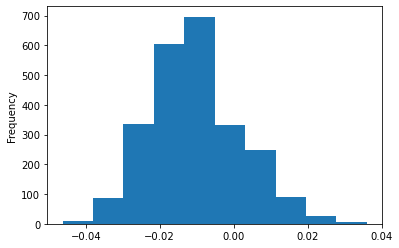

In [23]:
electrode_corrs.plot.hist()

In [ ]:
import seaborn as sns
sns.histplot(n400_df.V1)

In [ ]:
n400_df.V1.min()

## Sandbox

In [20]:
raw, run_offsets = utils.load_eeg(eeg_paths["1"], data_channels, reference_channels,
                                sample_rate=SAMPLE_RATE,
                                filter_low=FILTER_LOW,
                                filter_high=FILTER_HIGH)

Creating RawArray with float64 data, n_channels=130, n_times=22949
    Range : 0 ... 22948 =      0.000 ...   179.281 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=23546
    Range : 0 ... 23545 =      0.000 ...   183.945 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=23602
    Range : 0 ... 23601 =      0.000 ...   184.383 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=23635
    Range : 0 ... 23634 =      0.000 ...   184.641 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=23614
    Range : 0 ... 23613 =      0.000 ...   184.477 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=26399
    Range : 0 ... 26398 =      0.000 ...   206.234 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=21439
    Range : 0 ... 21438 =      0.000 ...   167.484 secs
Ready.
Creating RawArray with float64 data, n_channels=130, n_times=22421
    Range : 0 ... 22420

In [27]:
df = raw.to_data_frame(time_format=None)

In [29]:
df

,time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V121,V122,V123,V124,V125,V126,V127,V128,M1,M2
0,0.000000,2.818926e-11,5.009014e-11,3.903128e-11,4.098284e-11,3.295975e-11,3.274291e-11,4.597017e-11,3.838076e-11,3.512815e-11,...,4.206704e-11,4.727121e-11,3.816392e-11,3.512815e-11,4.163336e-11,4.358493e-11,2.298509e-11,3.794708e-11,3.388132e-15,-3.388132e-15
1,0.007812,1.214788e+00,1.095266e+00,1.459336e+00,-1.505512e-02,2.874301e-01,9.394002e-02,1.257309e-01,7.078548e-01,6.721809e-03,...,1.226124e+00,9.732945e-01,-5.014175e-01,6.113083e-01,7.247118e-01,4.831498e-01,3.019750e-01,4.587922e-01,-8.116049e-02,8.116049e-02
2,0.015625,2.416670e+00,2.180281e+00,2.793128e+00,-6.036744e-02,5.111118e-01,1.904406e-01,2.534569e-01,1.327587e+00,-5.867672e-02,...,2.376187e+00,1.891307e+00,-9.262710e-01,1.225581e+00,1.294887e+00,7.945739e-01,4.535295e-01,7.851499e-01,-1.563739e-01,1.563739e-01
3,0.023438,3.591367e+00,3.243181e+00,3.889571e+00,-1.652132e-01,6.103181e-01,2.885589e-01,3.822735e-01,1.776033e+00,-2.627489e-01,...,3.380131e+00,2.702745e+00,-1.210356e+00,1.840832e+00,1.577197e+00,7.839429e-01,3.204017e-01,8.565794e-01,-2.204966e-01,2.204966e-01
4,0.031250,4.725855e+00,4.274290e+00,4.667633e+00,-3.504979e-01,5.364951e-01,3.880258e-01,5.125078e-01,1.988437e+00,-6.574158e-01,...,4.180356e+00,3.366686e+00,-1.306508e+00,2.450486e+00,1.482280e+00,3.524833e-01,-1.840092e-01,5.893668e-01,-2.698306e-01,2.698306e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497822,3889.234375,-8.941658e-01,-8.237190e-01,-6.110218e-01,-3.761519e-01,-2.493198e+00,-2.675645e-01,6.279464e-01,-1.250507e+00,-2.405217e+00,...,-1.323489e+00,-3.535239e+00,1.378963e+00,2.635790e+00,-1.966989e+00,-4.993232e+00,-5.247750e-01,-1.040959e+01,-4.812990e-02,4.812990e-02
497823,3889.242188,-2.852971e-01,-2.283825e-01,-2.817159e-01,-2.584513e-01,-2.263608e+00,-3.038041e-01,4.478922e-01,-1.543759e+00,-2.603254e+00,...,-1.289627e+00,-2.930515e+00,1.126928e+00,2.209537e+00,-1.358489e+00,-4.655484e+00,-1.131719e+00,-9.235539e+00,-3.291328e-02,3.291328e-02
497824,3889.250000,1.664223e-02,5.655719e-02,-9.380791e-02,-1.603151e-01,-1.715050e+00,-2.565052e-01,2.857977e-01,-1.343773e+00,-2.148953e+00,...,-1.014656e+00,-2.095500e+00,7.997609e-01,1.593642e+00,-8.396935e-01,-3.580557e+00,-1.137941e+00,-6.893874e+00,-2.009968e-02,2.009968e-02
497825,3889.257812,7.509722e-02,9.573698e-02,-1.647476e-02,-7.634904e-02,-9.228553e-01,-1.453235e-01,1.387331e-01,-7.709276e-01,-1.204226e+00,...,-5.564174e-01,-1.091950e+00,4.154867e-01,8.351123e-01,-3.981708e-01,-1.942190e+00,-6.905788e-01,-3.678610e+00,-9.486085e-03,9.486085e-03


In [30]:
run_offsets

[0,
 22949,
 46495,
 70097,
 93732,
 117346,
 143745,
 165184,
 187605,
 210621,
 235622,
 258386,
 281943,
 305977,
 329374,
 377673,
 401934,
 426160,
 449921,
 473148]

In [31]:
run_dfs = [df.loc[start_idx:end_idx] for start_idx, end_idx
           in zip(run_offsets, run_offsets[1:] + [len(df)])]

In [34]:
run_dfs = [run_df.assign(time=run_df.time - run_df.time.min())
           for run_df in run_dfs]

In [35]:
run_dfs[19]

,time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V121,V122,V123,V124,V125,V126,V127,V128,M1,M2
473148,0.000000,4.065758e-11,3.599551e-11,4.217546e-11,4.006127e-11,3.838076e-11,3.507394e-11,4.260915e-11,4.315125e-11,4.027811e-11,...,4.472334e-11,3.946496e-11,4.288020e-11,3.941075e-11,5.003593e-11,3.941075e-11,4.027811e-11,4.987330e-11,3.884440e-15,-3.884440e-15
473149,0.007812,-9.826468e-01,-1.165635e+00,3.846394e-01,6.671185e-01,-6.992023e-02,4.036074e-01,4.878678e-01,3.673038e-01,9.536632e-01,...,-1.157918e+00,-1.297741e+00,2.902776e-01,3.245992e-01,3.602986e-01,8.344599e-01,2.309230e+00,-7.451786e-01,-7.706959e-03,7.706959e-03
473150,0.015625,-1.903667e+00,-2.257865e+00,7.147634e-01,1.277096e+00,-1.089524e-01,8.520530e-01,1.015532e+00,7.550347e-01,1.922845e+00,...,-1.971057e+00,-2.352203e+00,6.634865e-01,6.926305e-01,8.768987e-01,1.814589e+00,4.534183e+00,-1.310320e+00,-1.398189e-02,1.398189e-02
473151,0.023438,-2.710254e+00,-3.214244e+00,9.424680e-01,1.780141e+00,-9.196190e-02,1.380080e+00,1.612972e+00,1.182774e+00,2.922079e+00,...,-2.152868e+00,-2.958081e+00,1.184855e+00,1.136692e+00,1.684050e+00,3.056973e+00,6.595093e+00,-1.542245e+00,-1.759409e-02,1.759409e-02
473152,0.031250,-3.362828e+00,-3.988417e+00,1.034730e+00,2.142914e+00,-2.278412e-03,2.002842e+00,2.292815e+00,1.661703e+00,3.954841e+00,...,-1.522522e+00,-2.981907e+00,1.886448e+00,1.671923e+00,2.865120e+00,4.619616e+00,8.410519e+00,-1.342642e+00,-1.771119e-02,1.771119e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497822,192.765625,-8.941658e-01,-8.237190e-01,-6.110218e-01,-3.761519e-01,-2.493198e+00,-2.675645e-01,6.279464e-01,-1.250507e+00,-2.405217e+00,...,-1.323489e+00,-3.535239e+00,1.378963e+00,2.635790e+00,-1.966989e+00,-4.993232e+00,-5.247750e-01,-1.040959e+01,-4.812990e-02,4.812990e-02
497823,192.773438,-2.852971e-01,-2.283825e-01,-2.817159e-01,-2.584513e-01,-2.263608e+00,-3.038041e-01,4.478922e-01,-1.543759e+00,-2.603254e+00,...,-1.289627e+00,-2.930515e+00,1.126928e+00,2.209537e+00,-1.358489e+00,-4.655484e+00,-1.131719e+00,-9.235539e+00,-3.291328e-02,3.291328e-02
497824,192.781250,1.664223e-02,5.655719e-02,-9.380791e-02,-1.603151e-01,-1.715050e+00,-2.565052e-01,2.857977e-01,-1.343773e+00,-2.148953e+00,...,-1.014656e+00,-2.095500e+00,7.997609e-01,1.593642e+00,-8.396935e-01,-3.580557e+00,-1.137941e+00,-6.893874e+00,-2.009968e-02,2.009968e-02
497825,192.789062,7.509722e-02,9.573698e-02,-1.647476e-02,-7.634904e-02,-9.228553e-01,-1.453235e-01,1.387331e-01,-7.709276e-01,-1.204226e+00,...,-5.564174e-01,-1.091950e+00,4.154867e-01,8.351123e-01,-3.981708e-01,-1.942190e+00,-6.905788e-01,-3.678610e+00,-9.486085e-03,9.486085e-03


item
1     176.48
2     179.83
3     178.88
4     180.14
5     179.55
6     201.43
7     164.65
8     169.23
9     174.49
10    191.28
11    174.48
12    178.95
13    182.01
14    177.13
15    182.13
16    184.31
17    186.31
18    179.21
19    176.04
20    186.57
Name: onset_time, dtype: float64

In [46]:
comp = np.array(list(zip(stim_df.groupby("item").onset_time.max(), [run_df.time.max() for run_df in run_dfs])))

In [48]:
comp

array([[176.48     , 179.2890625],
       [179.83     , 183.953125 ],
       [178.88     , 184.390625 ],
       [180.14     , 184.6484375],
       [179.55     , 184.484375 ],
       [201.43     , 206.2421875],
       [164.65     , 167.4921875],
       [169.23     , 175.1640625],
       [174.49     , 179.8125   ],
       [191.28     , 195.3203125],
       [174.48     , 177.84375  ],
       [178.95     , 184.0390625],
       [182.01     , 187.765625 ],
       [177.13     , 182.7890625],
       [182.13     , 377.3359375],
       [184.31     , 189.5390625],
       [186.31     , 189.265625 ],
       [179.21     , 185.6328125],
       [176.04     , 181.4609375],
       [186.57     , 192.796875 ]])

In [47]:
comp[:, 1] - comp[:, 0]

array([  2.8090625,   4.123125 ,   5.510625 ,   4.5084375,   4.934375 ,
         4.8121875,   2.8421875,   5.9340625,   5.3225   ,   4.0403125,
         3.36375  ,   5.0890625,   5.755625 ,   5.6590625, 195.2059375,
         5.2290625,   2.955625 ,   6.4228125,   5.4209375,   6.226875 ])

In [49]:
pd.concat(run_dfs, keys=[i + 1 for i in range(len(run_dfs))], names=["run"])

time            V1            V2            V3  \
run                                                                
1   0         0.000000  2.818926e-11  5.009014e-11  3.903128e-11   
    1         0.007812  1.214788e+00  1.095266e+00  1.459336e+00   
    2         0.015625  2.416670e+00  2.180281e+00  2.793128e+00   
    3         0.023438  3.591367e+00  3.243181e+00  3.889571e+00   
    4         0.031250  4.725855e+00  4.274290e+00  4.667633e+00   
...                ...           ...           ...           ...   
20  497822  192.765625 -8.941658e-01 -8.237190e-01 -6.110218e-01   
    497823  192.773438 -2.852971e-01 -2.283825e-01 -2.817159e-01   
    497824  192.781250  1.664223e-02  5.655719e-02 -9.380791e-02   
    497825  192.789062  7.509722e-02  9.573698e-02 -1.647476e-02   
    497826  192.796875  3.610393e-11  3.089976e-11  2.905662e-11   

                      V4            V5            V6            V7  \
run                                                                  
1   0       4.098284e-11  3.295975e-11  3.274291e-11  4.597017e-11   
    1      -1.505512e-02  2.874301e-01  9.394002e-02  1.257309e-01   
    2      -6.036744e-02  5.111118e-01  1.904406e-01  2.534569e-01   
    3      -1.652132e-01  6.103181e-01  2.885589e-01  3.822735e-01   
    4      -3.504979e-01  5.364951e-01  3.880258e-01  5.125078e-01   
...                  ...           ...           ...           ...   
20  497822 -3.761519e-01 -2.493198e+00 -2.675645e-01  6.279464e-01   
    497823 -2.584513e-01 -2.263608e+00 -3.038041e-01  4.478922e-01   
    497824 -1.603151e-01 -1.715050e+00 -2.565052e-01  2.857977e-01   
    497825 -7.634904e-02 -9.228553e-01 -1.453235e-01  1.387331e-01   
    497826  2.341877e-11  1.843144e-11  1.951564e-11  3.838076e-11   

                      V8            V9  ...          V121          V122  \
run                                     ...                               
1   0       3.838076e-11  3.512815e-11  ...  4.206704e-11  4.727121e-11   
    1       7.078548e-01  6.721809e-03  ...  1.226124e+00  9.732945e-01   
    2       1.327587e+00 -5.867672e-02  ...  2.376187e+00  1.891307e+00   
    3       1.776033e+00 -2.627489e-01  ...  3.380131e+00  2.702745e+00   
    4       1.988437e+00 -6.574158e-01  ...  4.180356e+00  3.366686e+00   
...                  ...           ...  ...           ...           ...   
20  497822 -1.250507e+00 -2.405217e+00  ... -1.323489e+00 -3.535239e+00   
    497823 -1.543759e+00 -2.603254e+00  ... -1.289627e+00 -2.930515e+00   
    497824 -1.343773e+00 -2.148953e+00  ... -1.014656e+00 -2.095500e+00   
    497825 -7.709276e-01 -1.204226e+00  ... -5.564174e-01 -1.091950e+00   
    497826  1.723881e-11  3.089976e-11  ...  4.672911e-11  2.981556e-11   

                    V123          V124          V125          V126  \
run                                                                  
1   0       3.816392e-11  3.512815e-11  4.163336e-11  4.358493e-11   
    1      -5.014175e-01  6.113083e-01  7.247118e-01  4.831498e-01   
    2      -9.262710e-01  1.225581e+00  1.294887e+00  7.945739e-01   
    3      -1.210356e+00  1.840832e+00  1.577197e+00  7.839429e-01   
    4      -1.306508e+00  2.450486e+00  1.482280e+00  3.524833e-01   
...                  ...           ...           ...           ...   
20  497822  1.378963e+00  2.635790e+00 -1.966989e+00 -4.993232e+00   
    497823  1.126928e+00  2.209537e+00 -1.358489e+00 -4.655484e+00   
    497824  7.997609e-01  1.593642e+00 -8.396935e-01 -3.580557e+00   
    497825  4.154867e-01  8.351123e-01 -3.981708e-01 -1.942190e+00   
    497826  3.046608e-11  3.339343e-11  2.764716e-11  3.295975e-11   

                    V127          V128            M1            M2  
run                                                                 
1   0       2.298509e-11  3.794708e-11  3.388132e-15 -3.388132e-15  
    1       3.019750e-01  4.587922e-01 -8.116049e-02  8.116049e-02  
    2       4.535295e-01  7.851499e-01 -1.563739e-01  1.563